# Traveling Salesperson Problem

In [42]:
from utils import TSP

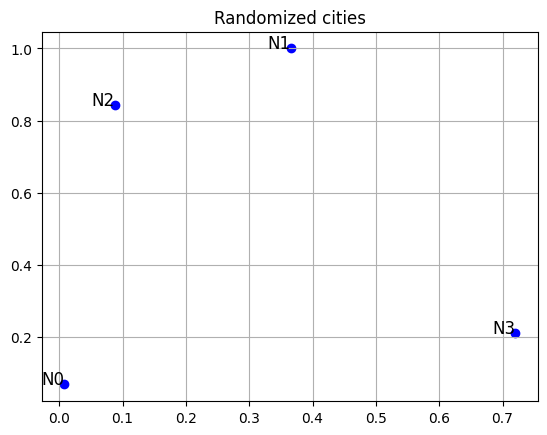

array([[0, 9, 7, 7],
       [9, 0, 3, 8],
       [7, 3, 0, 8],
       [7, 8, 8, 0]])

In [43]:
# Create a random TSP problem
tsp = TSP(4, initial_plot=True)
tsp.distance_matrix

## Brute force solve

Best order from brute force = (0, 2, 1, 3) with total distance = 25


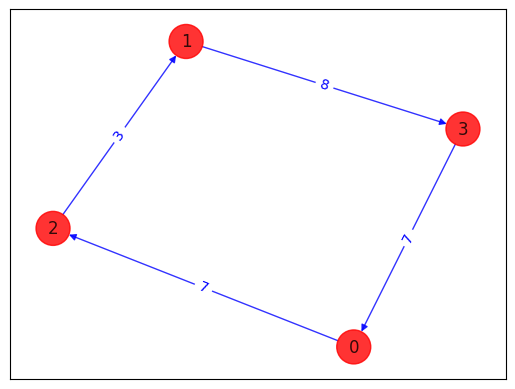

In [44]:
best_order, best_distance = tsp.brute_force()

tsp.draw_tour(best_order)
print(
    "Best order from brute force = "
    + str(best_order)
    + " with total distance = "
    + str(best_distance)
)

## Formulating QUBO

For $N$ cities, use $N^2$ binary variables x(i,p), where i represents the index of a city and p represents the order of the city in the route. In other words, if city i is visited at step p of the route, then x(i,p) = 1.

Constraints\
This euations ensure that each city is visited only once, and each step of the route is in one city.
$
\begin{gather}
\sum_{p=0}^{N-1} ( 1 - \sum_{i=0}^{N-1} x(i, p) )^2 = 0 \\
\sum_{i=0}^{N-1} ( 1 - \sum_{p=0}^{N-1} x(i, p) )^2 = 0 \\ 
\sum_{i=0}^{N-1} x_{i, p} = 1,\ for\ all\ p \\
\sum_{p=0}^{N-1} x_{i, p} = 1,\ for\ all\ i \\
\end{gather}
$

Objective\
Find the shortest Hamiltonian cycle in a graph
$
\begin{gather}
C(x) = \sum_{i, j} w_{i, j} \sum_{p=0}^{N-1} x_{i, p}x_{j, p + 1}  \\
\end{gather}
$

In [45]:
qubo = tsp.qubo(penalty=100, format="ising")
qubitOp = qubo["model"]
offset = qubo["offset"] 

print("Offset:", offset)
print("Ising Hamiltonian:")
print(str(qubitOp))

Offset: 756.0
Ising Hamiltonian:
SparsePauliOp(['IIIIIIIIIIIIIIIZ', 'IIIIIIIIIIIIIIZI', 'IIIIIIIIIIIIIZII', 'IIIIIIIIIIIIZIII', 'IIIIIIIIIIIZIIII', 'IIIIIIIIIIZIIIII', 'IIIIIIIIIZIIIIII', 'IIIIIIIIZIIIIIII', 'IIIIIIIZIIIIIIII', 'IIIIIIZIIIIIIIII', 'IIIIIZIIIIIIIIII', 'IIIIZIIIIIIIIIII', 'IIIZIIIIIIIIIIII', 'IIZIIIIIIIIIIIII', 'IZIIIIIIIIIIIIII', 'ZIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIZZ', 'IIIIIIIIIIIIIZIZ', 'IIIIIIIIIIIIZIIZ', 'IIIIIIIIIIIZIIIZ', 'IIIIIIIIIIZIIIIZ', 'IIIIIIIIZIIIIIIZ', 'IIIIIIIZIIIIIIIZ', 'IIIIIIZIIIIIIIIZ', 'IIIIZIIIIIIIIIIZ', 'IIIZIIIIIIIIIIIZ', 'IIZIIIIIIIIIIIIZ', 'ZIIIIIIIIIIIIIIZ', 'IIIIIIIIIIIIIZZI', 'IIIIIIIIIIIIZIZI', 'IIIIIIIIIIIZIIZI', 'IIIIIIIIIIZIIIZI', 'IIIIIIIIIZIIIIZI', 'IIIIIIIZIIIIIIZI', 'IIIIIIZIIIIIIIZI', 'IIIIIZIIIIIIIIZI', 'IIIZIIIIIIIIIIZI', 'IIZIIIIIIIIIIIZI', 'IZIIIIIIIIIIIIZI', 'IIIIIIIIIIIIZZII', 'IIIIIIIIIIZIIZII', 'IIIIIIIIIZIIIZII', 'IIIIIIIIZIIIIZII', 'IIIIIIZIIIIIIZII', 'IIIIIZIIIIIIIZII', 'IIIIZIIIIIIIIZII', 'IIZIIIIIIIIIIZII', 'IZIIIIIIIII

## Running on quantum computer
qiskit_algorithms QAOA not supported

In [46]:
from qiskit.circuit.library import QAOAAnsatz
import numpy as np

from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager


reps = 5
circuit = QAOAAnsatz(qubitOp, reps=reps)
# circuit.measure_all()

pm = generate_preset_pass_manager(optimization_level=1)
candidate_circuit = pm.run(circuit)

initial_gamma = np.pi
initial_beta = np.pi/2
init_params = []
for _ in range(reps):
    init_params.extend([initial_gamma, initial_beta])



In [47]:
objective_func_vals = [] # Global variable
def cost_func_estimator(params, ansatz, hamiltonian, estimator):

    # transform the observable defined on virtual qubits to
    # an observable defined on all physical qubits
    isa_hamiltonian = hamiltonian.apply_layout(ansatz.layout)

    pub = (ansatz, isa_hamiltonian, params)
    job = estimator.run([pub])

    results = job.result()[0]
    cost = results.data.evs

    objective_func_vals.append(cost)


    return cost

In [48]:
from scipy.optimize import minimize
from qiskit.primitives import StatevectorEstimator as Estimator

estimator = Estimator()
result = minimize(
    cost_func_estimator,
    init_params,
    args=(candidate_circuit, qubitOp, estimator),
    method="L-BFGS-B",
    tol=2000,
)
print(result)

  message: CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
  success: True
   status: 0
      fun: -6.1511278519723114e-15
        x: [ 3.142e+00  1.571e+00  3.142e+00  1.571e+00  3.142e+00
             1.571e+00  3.142e+00  1.571e+00  3.142e+00  1.571e+00]
      nit: 0
      jac: [-4.615e+02  4.615e+02  3.944e-08 -3.137e-06 -4.935e+02
             2.065e-06  3.465e-06  2.790e-06  3.018e-06  9.289e-08]
     nfev: 11
     njev: 1
 hess_inv: <10x10 LbfgsInvHessProduct with dtype=float64>


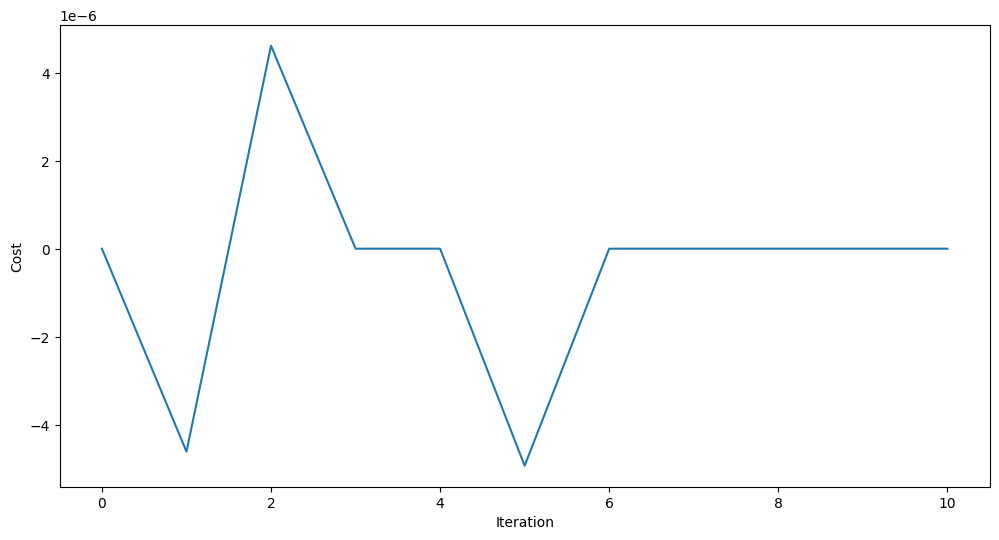

In [49]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(objective_func_vals)
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.show()

In [50]:
optimized_circuit = candidate_circuit.assign_parameters(result.x)
optimized_circuit.measure_all()
# optimized_circuit.draw('mpl', fold=False, idle_wires=False)

In [51]:
from qiskit.primitives import StatevectorSampler as Sampler
sampler = Sampler() 

pub = (optimized_circuit, )

job = sampler.run([pub], shots=1000)
counts_int = job.result()[0].data.meas.get_int_counts()
counts_bin = job.result()[0].data.meas.get_counts()
shots = sum(counts_int.values())
final_distribution_int = {key: val/shots for key, val in counts_int.items()}
final_distribution_bin = {key: val/shots for key, val in counts_bin.items()}
print(final_distribution_int)

{60195: 0.0001, 29757: 0.0001, 35473: 0.0001, 49608: 0.0001, 59491: 0.0001, 20970: 0.0001, 135: 0.0001, 322: 0.0001, 52569: 0.0001, 23822: 0.0001, 387: 0.0001, 20166: 0.0002, 39249: 0.0001, 38119: 0.0001, 28180: 0.0001, 59763: 0.0001, 9860: 0.0001, 35259: 0.0002, 45048: 0.0001, 54514: 0.0001, 41014: 0.0001, 31679: 0.0001, 18848: 0.0002, 33350: 0.0001, 58865: 0.0001, 1600: 0.0001, 30017: 0.0001, 22107: 0.0001, 4190: 0.0001, 29017: 0.0001, 26756: 0.0001, 28214: 0.0001, 17145: 0.0001, 39553: 0.0001, 28448: 0.0001, 30250: 0.0001, 6860: 0.0001, 43873: 0.0001, 26505: 0.0001, 42517: 0.0002, 64284: 0.0001, 48790: 0.0001, 47762: 0.0003, 11286: 0.0001, 5900: 0.0001, 38857: 0.0001, 8094: 0.0003, 21452: 0.0001, 59343: 0.0001, 12917: 0.0002, 12505: 0.0002, 64367: 0.0002, 23805: 0.0001, 8999: 0.0001, 53931: 0.0004, 60753: 0.0001, 7049: 0.0002, 17019: 0.0003, 22225: 0.0001, 60172: 0.0001, 5131: 0.0002, 48469: 0.0001, 33712: 0.0001, 19661: 0.0001, 52111: 0.0001, 38142: 0.0001, 27247: 0.0001, 20360: 0.

In [52]:
# auxiliary functions to sample most likely bitstring
def to_bitstring(integer, num_bits):
    result = np.binary_repr(integer, width=num_bits)
    return [int(digit) for digit in result]

keys = list(final_distribution_int.keys())
values = list(final_distribution_int.values())
most_likely = keys[np.argmax(np.abs(values))]
most_likely_bitstring = to_bitstring(most_likely, 16)
most_likely_bitstring.reverse()

print("Result bitstring:", most_likely_bitstring)


result = tsp.interpret(most_likely_bitstring)

Result bitstring: [1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1]


In [53]:
result

array([3., 2., 3., 3.])